In [7]:
import os
import cv2
import shutil
import numpy as np

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class CanDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with all the images (can be train or test).
            transform (callable, optional): Optional transform to be applied on a sample.
            is_test (bool, optional): Whether the dataset is for test set (no labels).
        """
        self.root_dir = root_dir
        self.transform = transform
        #self.is_test = is_test  # Flag to indicate if it's the test dataset
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, file_name))
                    self.labels.append(label)  # Add label only for training set
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Crea il dataset di train e test
train_dataset = CanDataset(root_dir='Monster_energy_drink_png/Monster_energy_drink/train', transform=transform)
test_dataset = CanDataset(root_dir='Monster_energy_drink_png/Monster_energy_drink/test', transform=transform)

# Crea i dataloader per il dataset di train e test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Stampa alcune informazioni sui dataset
print(f"Numero di immagini nel dataset di train: {len(train_dataset)}")
print(f"Numero di immagini nel dataset di test: {len(test_dataset)}\n")
print(f"Classi nel dataset di train: {train_dataset.classes}")
print(f"Classi nel dataset di test: {test_dataset.classes}")

Numero di immagini nel dataset di train: 1478
Numero di immagini nel dataset di test: 620

Classi nel dataset di train: ['Aussie Lemonade', 'Mango Loco', 'Original green', 'Pacific Punch', 'java salted caramel', 'lo carb', 'nitro cosmic peach', 'nitro super dry', 'tea lemonade', 'ultra black', 'ultra blue', 'ultra gold', 'ultra peachy keen', 'ultra red', 'ultra rosa', 'ultra strawberry dreams', 'ultra sunrise', 'ultra violet', 'ultra watermelon']
Classi nel dataset di test: ['Aussie Lemonade', 'Mango Loco', 'Original green', 'Pacific Punch', 'java salted caramel', 'lo carb', 'nitro cosmic peach', 'nitro super dry', 'tea lemonade', 'ultra black', 'ultra blue', 'ultra gold', 'ultra peachy keen', 'ultra red', 'ultra rosa', 'ultra strawberry dreams', 'ultra sunrise', 'ultra violet', 'ultra watermelon']


In [9]:
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import torch
import torch.nn as nn

# Definisci il dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica il modello pre-addestrato ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modifica l'ultimo layer per adattarlo al numero di classi del dataset
num_features = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_features, num_classes) # model.fc è l'ultimo layer fully connected della ResNet

# Sposta il modello sul dispositivo
model = model.to(device)

# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss() # Loss function adatta ai problemi di classificazione multi-classe.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the list to store loss values
loss_values = []

# Funzione per addestrare il modello
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Azzerare i gradienti
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass e ottimizzazione
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            epoch_loss = running_loss / len(train_loader)
            loss_values.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return loss_values

# Addestra il modello e ottieni i valori di perdita
loss_values = train_model(model, train_loader, criterion, optimizer, num_epochs=15)

/Users/martinapanini/.pyenv/versions/3.10.12/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15, Loss: 1.4639
Epoch 2/15, Loss: 0.7030
Epoch 3/15, Loss: 0.6204
Epoch 4/15, Loss: 0.3892
Epoch 5/15, Loss: 0.3289
Epoch 6/15, Loss: 0.4063
Epoch 7/15, Loss: 0.3505
Epoch 8/15, Loss: 0.3507
Epoch 9/15, Loss: 0.1963
Epoch 10/15, Loss: 0.3655
Epoch 11/15, Loss: 0.3154
Epoch 12/15, Loss: 0.1812
Epoch 13/15, Loss: 0.1905
Epoch 14/15, Loss: 0.0901
Epoch 15/15, Loss: 0.1224


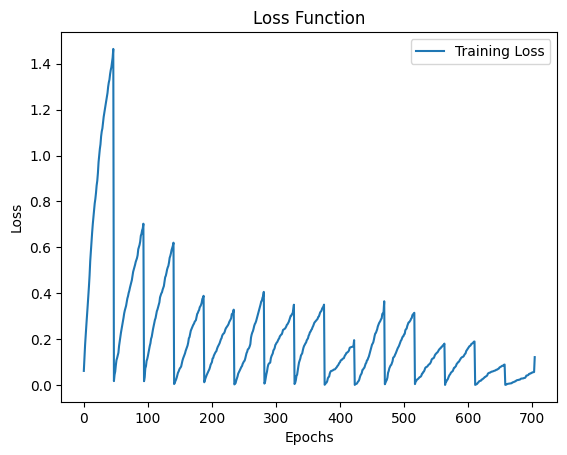

In [ ]:
import matplotlib.pyplot as plt
# Plot dei valori di perdita
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.legend()
plt.show()